# 01 - Explore IHDP Dataset

In this notebook, we load and explore the IHDP dataset using `causalml`. 
The dataset simulates a clinical trial with binary treatment, continuous outcome, and observed counterfactuals.

Our goals:
- Understand the structure of the data
- Explore distributions of covariates, treatment, outcomes
- Visualize heterogeneity in treatment effects (τ)


In [ ]:
# Imports
import numpy as np
import pandas as pd
import plotly
import plotly.figure_factory as ff
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data


In [ ]:
import pandas as pd
import numpy as np

# Load from your CSV file
df = pd.read_csv("../data/simulated_data.csv")
df.head()

In [ ]:
# Extract components
x = df[[col for col in df.columns if col.startswith("x")]].values  # Covariates as numpy array
t = df["treatment"].values                                         # Treatment assignment
yf = df["outcome"].values                                          # Observed outcome
ycf = df["counterfactual"].values                                  # Counterfactual outcome (only in simulated data)
mu0 = df["mu0"].values                                             # True expected outcome under control
mu1 = df["mu1"].values                                             # True expected outcome under treatment

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,treatment,outcome,mu0,mu1,tau,counterfactual,propensity_score
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,1,3.672942,2.352336,3.600693,1.248357,3.282869,0.339080
1,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,1,-4.189167,-4.395296,-3.627005,0.768291,-5.056137,0.751966
2,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,0,-3.214384,-2.639197,-0.906373,1.732824,-2.328432,0.648280
3,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0,0.517742,0.529643,1.228789,0.699147,1.443821,0.554136
4,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,0,-4.719485,-4.079339,-2.710106,1.369233,-1.636739,0.494940


## Dataset Description

This project also includes a **fully synthetic dataset**, generated with controlled treatment assignment and outcome mechanisms. It allows rigorous benchmarking of causal inference methods, since the true counterfactual outcomes and treatment effects are known by design.

* The **covariates** (`x0`–`x9`) are drawn from a multivariate normal distribution.
* The **treatment assignments** are simulated using a logistic function of the covariates to induce confounding.
* The **outcomes** are generated using a nonlinear outcome model that depends on both covariates and treatment, introducing **heterogeneous treatment effects**.

### Columns

* `x0` to `x9`: Simulated covariates (numeric features representing individual-level attributes)
* `treatment`: **Simulated** binary treatment assignment (1 = treated, 0 = control), probabilistically assigned based on covariates
* `outcome`: **Simulated** observed (factual) outcome for the assigned treatment
* `counterfactual`: **Simulated** unobserved outcome under the *opposite* treatment assignment
* `mu0`: **Simulated** expected outcome under control (`E[Y(0) | X]`)
* `mu1`: **Simulated** expected outcome under treatment (`E[Y(1) | X]`)
* `tau`: **True individual treatment effect** for each unit, defined as `mu1 - mu0`
* `propensity_score`: True probability of receiving treatment given covariates (`P(T=1 | X)`)

This dataset is ideal for validating causal inference pipelines — especially those estimating **individual treatment effects (ITE)** or **average treatment effects (ATE)** — under known ground truth.

## Check Dimensions

In [60]:
df['treatment'].value_counts()

treatment
1    524
0    476
Name: count, dtype: int64

### Summary Stats

In [61]:
df.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,treatment,outcome,mu0,mu1,tau,counterfactual,propensity_score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.010788,0.031292,-0.022542,-0.043075,0.013622,-0.029252,-0.002689,0.005495,-0.023104,0.038105,0.524000,0.471568,-0.025524,0.979870,1.005394,0.477614,0.509566
std,1.005433,1.016046,0.983366,0.983406,1.012645,1.037024,1.031230,1.030962,0.986846,0.945284,0.499674,2.130465,1.891853,1.931756,0.502716,2.267809,0.203640
min,-3.922400,-3.688365,-3.241267,-2.943142,-3.138515,-3.170426,-2.801912,-3.601085,-3.007632,-3.176704,0.000000,-6.383501,-6.645517,-5.147727,-0.961200,-7.135037,0.040133
25%,-0.616527,-0.631506,-0.702626,-0.750008,-0.651541,-0.749592,-0.744779,-0.713176,-0.650034,-0.559290,0.000000,-1.026562,-1.299433,-0.271884,0.691736,-0.997664,0.351296
50%,0.014006,0.007605,-0.015036,-0.001346,-0.012020,-0.012086,-0.024976,-0.013284,-0.003221,0.019097,1.000000,0.493384,0.029259,1.011532,1.007003,0.605518,0.509352
75%,0.679698,0.685621,0.613766,0.638310,0.721896,0.680087,0.683319,0.696602,0.608861,0.687027,1.000000,1.901771,1.242778,2.223889,1.339849,2.057749,0.670495
max,3.076860,3.529055,3.152057,3.117681,2.935658,3.926238,3.243093,3.137749,3.377383,3.852731,1.000000,6.644481,6.249235,7.748240,2.538430,7.759614,0.963084


## Visualize Treatment and Outcomes

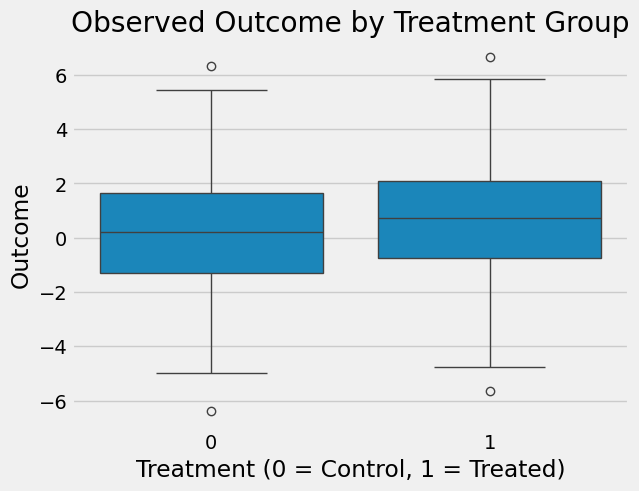

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df, x='treatment', y='outcome')
plt.title("Observed Outcome by Treatment Group")
plt.xlabel("Treatment (0 = Control, 1 = Treated)")
plt.ylabel("Outcome")
plt.show()


* **Treated group has higher median outcome** → suggests positive treatment effect.
* **Outcome variability is higher** in treated.
* **Distributions overlap** → implies need for causal methods.
* **Outliers exist** in both groups → consider robust modeling.

In [63]:
# Only keep rows where outcome < 50
filtered_df = df[df['outcome'] < 50]

treated = filtered_df[filtered_df["treatment"] == 1]["outcome"]
control = filtered_df[filtered_df["treatment"] == 0]["outcome"]

fig = ff.create_distplot(
    [control, treated],
    group_labels=["Control", "Treated"],
    show_hist=False,
    show_rug=False
)

fig.update_layout(
    title="Outcome Distribution (Clipped at Outcome < 50)",
    xaxis_title="Outcome",
    yaxis_title="Density"
)

fig.show()


### 🔍 What we see:

* **Treated distribution is right-shifted** → consistent with higher outcomes.
* **More mass above 0 for treated group** → treatment likely beneficial.
* **Control group has more density on the left** → worse outcomes.
* **Distributions overlap but are distinguishable** → good candidate for causal estimation.

## Checking for imbalance using KDEs for each feature

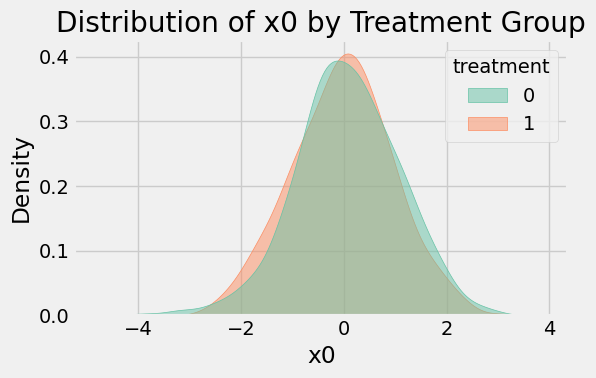

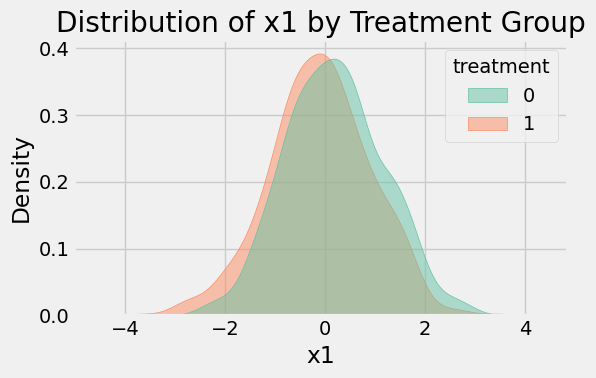

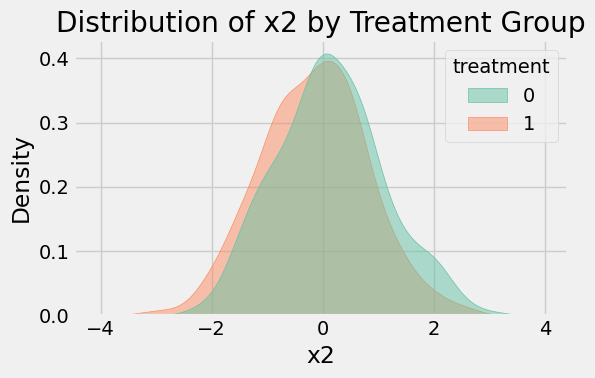

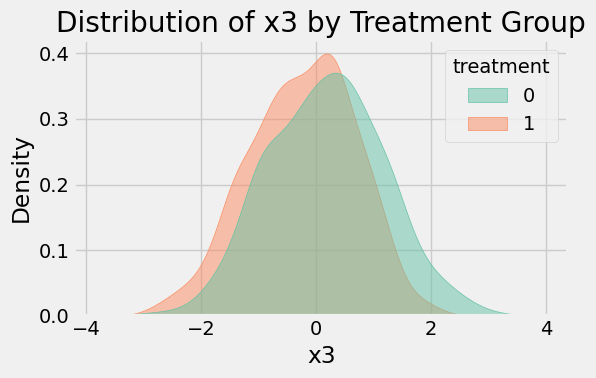

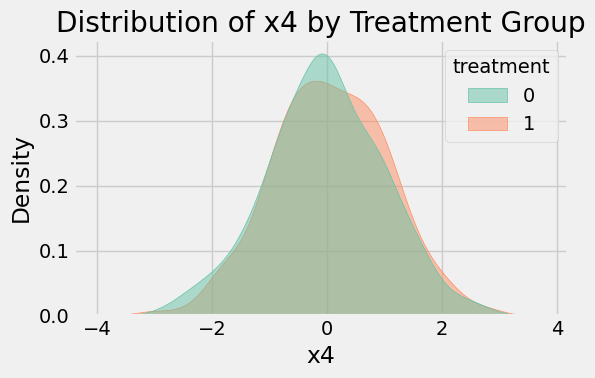

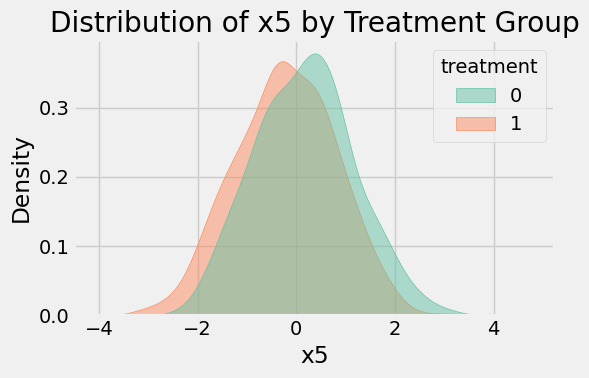

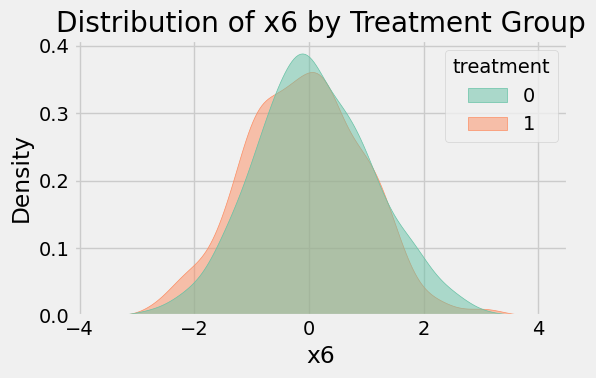

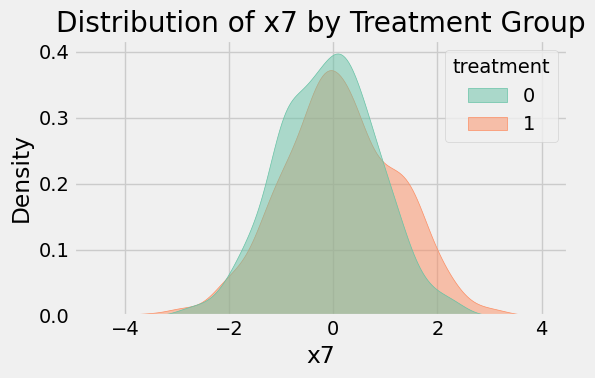

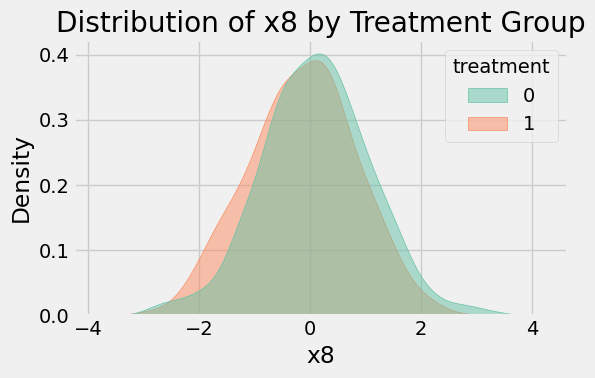

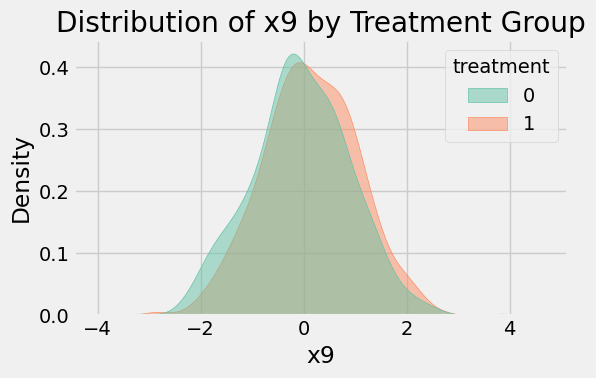

In [65]:
# Loop through all x-features
features = [f'x{i}' for i in range(10)]  # x0 to x24

for col in features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='treatment', common_norm=False, fill=True, palette='Set2', alpha=0.5)
    plt.title(f'Distribution of {col} by Treatment Group')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

* Lets check for imbalance using index also!

## Visualize Standardized Mean Differences (SMD)

In [ ]:
from sklearn.preprocessing import StandardScaler
# Assume df is your loaded DataFrame
X = df[[col for col in df.columns if col.startswith("x")]]
T = df["treatment"]

# Standardize features (important for SMD)
X_std = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Compute SMD
treated = X_std[T == 1]
control = X_std[T == 0]
smd = (treated.mean() - control.mean()).abs()

# Plot
smd_df = smd.sort_values(ascending=False).reset_index()
smd_df.columns = ["Covariate", "SMD"]

fig = px.bar(
    smd_df, x="SMD", y="Covariate", orientation="h",
    title="Standardized Mean Differences (SMD) Before Adjustment"
)
fig.show()

🔍 Interpretation: <br>
SMD ≈ 0 → perfect balance

SMD > 0.1 → mild imbalance

SMD > 0.25 → strong imbalance (needs adjustment)

This indicates substantial imbalance between treated and control groups.

For causal inference, this violates the “ignorability” or “unconfoundedness” assumption, meaning treatment assignment is not independent of covariates.

 ## trimming + IPW + rebalancing correctly using logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression

# X = covariates DataFrame, T = treatment Series
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, T)
ps_scores = ps_model.predict_proba(X)[:, 1]

In [70]:
# Define bounds (e.g., 1st to 99th percentile of scores for overlap)
lower = np.percentile(ps_scores[T == 1], 1)
upper = np.percentile(ps_scores[T == 0], 99)

# Apply trimming
mask = (ps_scores >= lower) & (ps_scores <= upper)
X_trimmed = X[mask].reset_index(drop=True)
T_trimmed = T[mask].reset_index(drop=True)


In [71]:
ps_model_trimmed = LogisticRegression(max_iter=1000)
ps_model_trimmed.fit(X_trimmed, T_trimmed)
ps_trimmed = ps_model_trimmed.predict_proba(X_trimmed)[:, 1]

In [72]:
# Avoid division by zero
epsilon = 1e-6
ps_trimmed = np.clip(ps_trimmed, epsilon, 1 - epsilon)

weights_ipw = T_trimmed / ps_trimmed + (1 - T_trimmed) / (1 - ps_trimmed)

In [73]:
def compute_weighted_smd(X, T, weights):
    treated = X[T == 1]
    control = X[T == 0]
    w_treated = weights[T == 1]
    w_control = weights[T == 0]

    mean_t = np.average(treated, weights=w_treated, axis=0)
    mean_c = np.average(control, weights=w_control, axis=0)
    var_t = np.average((treated - mean_t) ** 2, weights=w_treated, axis=0)
    var_c = np.average((control - mean_c) ** 2, weights=w_control, axis=0)

    smd = np.abs(mean_t - mean_c) / np.sqrt((var_t + var_c) / 2)
    return pd.Series(smd, index=X.columns)

smd_weighted = compute_weighted_smd(X_trimmed, T_trimmed.values, weights_ipw)
smd_df = smd_weighted.sort_values(ascending=False).reset_index()
smd_df.columns = ["Covariate", "SMD"]


In [74]:
fig = px.bar(smd_df, x="SMD", y="Covariate", orientation="h",
             title="Standardized Mean Differences (SMD) After IPW (Trimmed)",
             labels={"SMD": "Standardized Mean Difference", "Covariate": "Covariate"})
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()


Excellent result. Here's a concise assessment:

### Insights from Your Result:

* **All covariates are now below the 0.1 SMD threshold** (most are even < 0.02).
* This indicates **strong covariate balance** after:

  * Trimming for overlap
  * Logistic regression-based propensity score modeling
  * Inverse Probability Weighting (IPW)

### What this means:

* Our adjustment worked — **I can now proceed with outcome modeling** (e.g., AIPW, S-learner, T-learner, etc.) with more confidence in the **unconfoundedness assumption**.
* I likely addressed most of the confounding bias in this simulation setup.


## Doubly Robust Estimation (AIPW)

In [75]:
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression

# 1. Prepare data
X = df[[col for col in df.columns if col.startswith("x")]]
T = df["treatment"]
Y = df["outcome"]

# 2. Fit Propensity Model
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, T)
propensity_score = ps_model.predict_proba(X)[:, 1]

# 3. Fit Outcome Models
model_treated = XGBRegressor()
model_control = XGBRegressor()

model_treated.fit(X[T == 1], Y[T == 1])
model_control.fit(X[T == 0], Y[T == 0])

mu1_hat = model_treated.predict(X)
mu0_hat = model_control.predict(X)

# 4. AIPW Estimator for Individual Treatment Effect (ITE)
aipw_ite = (
    (T / propensity_score) * (Y - mu1_hat)
    - ((1 - T) / (1 - propensity_score)) * (Y - mu0_hat)
    + (mu1_hat - mu0_hat)
)

# 5. Average Treatment Effect (ATE)
aipw_ate = aipw_ite.mean()
print(f"AIPW ATE: {aipw_ate:.4f}")

AIPW ATE: 0.8698


In [76]:
true_ate = df["tau"].mean()
print(f"True ATE (from data): {true_ate:.4f}")
print(f"AIPW ATE (estimated): {aipw_ate:.4f}")

True ATE (from data): 1.0054
AIPW ATE (estimated): 0.8698


The AIPW estimator performed reasonably well: only ~0.13 error.

This indicates:

Your propensity model (used in IPW) is good enough.

Your outcome model is also doing okay.

The bias is modest, especially in semi-synthetic settings.

## Next Steps

- Build T-learner model using `XGBoost`
- Estimate τ(x) and compare to true τ
- Use PEHE and ATE as evaluation metrics